In [1]:
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
from src.models.time_series_model import HiddenMarkovModel
from src.models.transition_models import PLRNN
import yaml
import pyro
import inspect

# Hydra

The key feature is the ability to dynamically create a hierarchical configuration by composition and override it through config files and the command line.

This helps to prevent cluttering the code with args. A simple hydra wrapper (see main file) is enough to connect the code to the configuration files

A common pattern is to create a default config from which other configs can inherit and only override certain components. In the following my default config.

AS you can see it is hierarchically organized. Each component of a ML Pipeline is given a certain section. The name of the section (e.g. transition_model) has to correspond to a directory name in the config directory ( e.g. `conf /transition_model`). The value corresponds to a certain yaml file ( e.g.` conf /transition_model / dendPLRNN.yaml`)

In [64]:
default_config_path = "conf\default_config.yaml"

def print_yaml(path):
    with open(path, "r") as f:
        print(f.read())


print_yaml(default_config_path)

defaults:
  - _self_
  - data: data_module
  - module: annealing_module
  - guide: rnn
  - loss: loss
  - observation_model: linear
  - transition_model: dendPLRNN
  - observation_distribution: normal
  - transition_distribution: normal
  - optimizer: adam
  - training: train
  - metriccollection: metriccollection


z_dim: 5
obs_dim: 19




Lets look in one of the yaml files:

In [5]:
dend_plrnn_path = r"conf\transition_model\dendPLRNN.yaml"
print_yaml(dend_plrnn_path)

_target_: src.models.transition_models.PLRNN
z_dim: ${z_dim}
connectivity_module:
  _target_: src.models.transition_models.DendriticConnector
  z_dim: ${z_dim}
  B: 10
cov_module:
  _target_: src.models.transition_models.ConstantCovariance
  z_dim: ${z_dim}


Multiple things to note here:
- \_target_ keyword is reserved for paths of classes. This helps to instantiate objects  (we'll see an example in a moment) without writing boiler plate code like

In [66]:
config = {"transition_model" : "dendPLRNN"}
if config["transition_model"] == "dendPLRNN":
    ... #instantiate something

- The instantiation can be nested. Often it is the case that to instantiate an object one has to first instantiate other objects that need be passed to the constructur. This can easily be done via hydra. E.g. in this example to instantiate a plrnn model one needs two modules: one for the mean vector of the normal distribution and one for the covariance.
- you can reference values  of the final config file. E.g. the hidden dimension  is a parameter that is needed all over the place to instantiate Neural NEtworks with respective sizes. Instead of repeating it all over again we can define it at the top and reference it where needed. E.g. via `${z_dim}`


In this Notebook we will try to replicate the multi modal teacher forcing Pipeline. The respective config file denotes the relative changes. The code is writte to be modular. So it is easy to swap components

In [6]:
multimodal_teacher_forcing_path = r"conf\experiments\multimodal_teacher_forcing.yaml"
print_yaml(multimodal_teacher_forcing_path)

defaults:
  - default_config
  - _self_
  - override observation_model: multi_modal
  - override loss: force_elbo
  - override observation_distribution: product_distribution
  - override data: multimodal_fake_data


observation_model:
  sub_models:
    normal_link:
      obs_dim: 4
    multinomial_link:
      obs_dim: 3
    poisson_link:
      obs_dim: 2

#obs dim has to be sum of all obs_dim in observation_models
obs_dim: 9

data:
  n_rois: 4
  n_categorical: 3
  n_poisson: 2

loss:
  forcing_interval: 20


hydra:
  searchpath:
    - file://conf


Lets now initialze the multi modal teacher forcing  config. This is what will be passed to the main function if wrapped in the hydra wrapper. We will call resolve to resolve references like `${z_dim}`

In [7]:
with initialize( version_base  = None, config_path="conf/experiments"):
    cfg = compose(config_name="multimodal_teacher_forcing.yaml")
    OmegaConf.resolve(cfg)

In [8]:
print(OmegaConf.to_yaml(cfg))

z_dim: 5
obs_dim: 9
data:
  _target_: src.data.dataloader.FakeMultiModalDataModule
  n_rois: 4
  'n': 1
  T: 512
  n_categories: 4
  n_categorical: 3
  n_poisson: 2
module:
  beginning_annealing_factor: 0.1
  annealing_epochs: 100
guide:
  _target_: src.models.guides.RNNGuide
  rnn:
    _target_: torch.nn.RNN
    input_size: 9
    hidden_size: 10
    nonlinearity: relu
    batch_first: true
    bidirectional: false
    num_layers: 1
    dropout: 0
  combiner:
    _target_: src.models.guides.Combiner
    z_dim: 5
    rnn_dim: 10
  dist:
    _target_: hydra.utils.get_class
    path: pyro.distributions.Normal
loss:
  _target_: src.training.losses.TeacherForcingTraceELBO
  forcing_interval: 20
observation_model:
  sub_models:
    normal_link:
      _target_: src.models.observation_models.LinearObservationModel
      obs_dim: 4
      z_dim: 5
    multinomial_link:
      _target_: src.models.observation_models.MultionomialLink
      obs_dim: 3
      z_dim: 5
      n_categories: 4
    poisson

In [9]:
transition_model_config = cfg.transition_model
print(OmegaConf.to_yaml(transition_model_config))

_target_: src.models.transition_models.PLRNN
z_dim: 5
connectivity_module:
  _target_: src.models.transition_models.DendriticConnector
  z_dim: 5
  B: 10
cov_module:
  _target_: src.models.transition_models.ConstantCovariance
  z_dim: 5



to instantiate a model with hydra one uses the instantiate function:

In [65]:
transition_model = instantiate(transition_model_config)
transition_model

PLRNN(
  (diag): Diagonal()
  (connectivity_module): DendriticConnector(
    (off_diag): OffDiagonal()
    (phi): DendriticPhi(
      (relu): ReLU()
    )
  )
  (cov_module): ConstantCovariance()
)

In [11]:
observation_model = instantiate(cfg.observation_model)
observation_distribution = instantiate(cfg.observation_distribution)
transition_distribution = instantiate(cfg.transition_distribution)


In [12]:
observation_distribution

abc.Normal x Categorical x Poisson

# Pyro

Pyro is a probabilistic programming language written in python which is compatible with pytorch models.

for an intro i recommend reading the examples:

https://pyro.ai/examples/intro_long.html  for a qucik overview


https://pyro.ai/examples/minipyro.html #in order to understand what is going on under the hood. Note that there is an example at the bottom


The point of this notebook is to show how elegantly  one can implement training pipelines without changing the underlying model

To set the stage:  I've implemented a class that is capable to represent any plrnn model. Namely the `HiddenMarkovModel` class. It requires 4 objects to instantiate:

- An observation Model which should be an  nn.Module
- A transition Model also an nn.Module
- An observation distribution  a  TorchDistribution
- An transition distribution also a TorchDistribution

The Models should return the parameters for the distributions. The user is responsible to take care that the shapes match. 

When Calling the HiddenMarkoVModel under the hood the following is run for all time steps:

In [76]:
import torch
import torch.nn  as nn
z_0  =nn.Parameter(torch.zeros(transition_model.z_dim))

z_1_params = transition_model(z_0)
z_1_dist = transition_distribution(*z_1_params)
z_1 = pyro.sample("z_1",z_1_dist)

x_1_params = observation_model(z_1)
x_1_dist = observation_distribution(*x_1_params)
x_1 = pyro.sample("x_1", x_1_dist)

x_1

tensor([[ 0.5843,  0.9101, -1.0782,  0.8000,  0.0000,  3.0000,  1.0000,  0.0000,
          0.0000]])

Now the magic happens in the `pyro.sample` statement. It has quite a few side effects. It looks up a so call Pyro Stack that contains a list of so called messengers (which are context managers) which influence what the statement actually does.
This helps to decouple model building from building the training pipeline. We will replicate the MTF pipeline using these messengers. If you want a deep dive into how exactly this works again consider the minipyro example: 
https://pyro.ai/examples/minipyro.html


In [58]:
hmm = HiddenMarkovModel(transition_model, observation_model, observation_distribution,transition_distribution)
# in pyro the variational distribution is called guide, we are considering an amortized variational inference approach. In the mtf code they refer to it as an encoder. We will use the name "encoder" from now on
armotized_variational_distribution_model = encoder = guide = instantiate(cfg.guide) 

In [31]:
data_module = instantiate(cfg.data)
data_module.setup("")
data_loader = data_module.train_dataloader()
batch = list(data_loader)[0]
batch[0][0]

The MTF Pipeline try to minimize the loss:

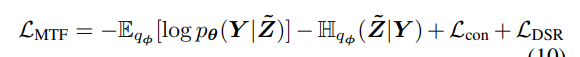

Now the first three terms of this loss are in my understanding just the vanilla negative elbo when using the plrnn + observation models as a model prior and the  encoder as a variational distribution.

In pyro the following representation of the elbo is used:


$\mathcal{L}(\phi, \theta; Y) = -\mathbb{E}_{q_\phi}\left[ \ln(p_\theta(x,z)
) - \ln(q_\phi(z\vert x)) \right]$ 



In order to calculate the L_MTF loss we have to do the following steps:

1. sample $z$ from $p_\phi$ 

In [77]:
encoder_trace = pyro.poutine.trace(encoder).get_trace(batch)
encoder_trace.nodes["z_1"]

{'type': 'sample',
 'name': 'z_1',
 'fn': Independent(MaskedDistribution(), 1),
 'is_observed': False,
 'args': (),
 'kwargs': {},
 'value': tensor([[ 0.3320, -0.0762, -0.8590, -0.0478, -0.3612]], grad_fn=<AddBackward0>),
 'infer': {'_markov_scope': Counter(), '_markov_depth': 1},
 'scale': 1.0,
 'mask': None,
 'cond_indep_stack': (),
 'done': True,
 'stop': False,
 'continuation': None}

2. run $p_\theta$ with samples from 1. This can be achieved with the replay messenger of pyro

In [ ]:
plrnn_trace = pyro.poutine.trace(pyro.poutine.replay(hmm, encoder_trace)).get_trace(batch)

#check that the z samples are indeed the ones from the encoder trace
plrnn_trace.nodes["z_7"]["value"] == encoder_trace.nodes["z_7"]["value"]

3. calculate the log probability

In [51]:
log_prob_p = plrnn_trace.log_prob_sum()
log_prob_q = encoder_trace.log_prob_sum()

4. Calculate $\tilde{\mathcal{L}}(\phi, \theta; Y)$

In [56]:
neg_elbo  = log_prob_q - log_prob_p

5. Rerun $p_\theta$ where only each $\tau$-th hidden state  of the encoder trace is used. For this one needs to implement a custom messenger which is straightforward to do

In [59]:
from src.training.forcing_interval_replay import force
tau = 30 
forced_plrnn_trace = pyro.poutine.trace(force(hmm, encoder_trace, tau)).get_trace(batch)

In [61]:
forced_plrnn_trace.nodes[f"z_{tau}"]["value"] == encoder_trace.nodes[f"z_{tau}"]["value"]

tensor([[True, True, True, True, True]])

In [62]:
forced_plrnn_trace.nodes[f"z_{tau+1}"]["value"] == encoder_trace.nodes[f"z_{tau+1}"]["value"]

tensor([[False, False, False, False, False]])

6. calculate log probability of observations $\log p_\theta(Y \vert Z) =- \mathcal{L}_{DSR}$

In [63]:
loss_dsr = - forced_plrnn_trace.log_prob_sum(site_filter=lambda s,t:  "x" in s)

7. calculate $\mathcal{L}_{MTF}$

In [ ]:
loss_mtf = neg_elbo + loss_dsr

The gradients are tracked by the way and can be used for gradient descent.